# 1. Load libraries and define functions

In [1]:

# Define functions needed for visualisation

import torch
from baselines.ViT.ViT_explanation_generator import Baselines

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX

from baselines.ViT.ViT_LRP import vit_base_patch16_224
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_for_cam
from baselines.ViT.ViT_explanation_generator import LRP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask, method='default', p=False):
    if method=='full' and not p:
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_HOT)
    else:   
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

model = vit_for_cam(pretrained=True).to(device)
baselines = Baselines(model)

# initialize ViT pretrained
model = vit_base_patch16_224(pretrained=True).to(device)
model.eval()
attribution_generator = LRP(model)

name_map_baselines = {
    "VTA":'transformer_attribution', "FLRP":"full", 'PFRP':"last_layer", "raw_attn":"attn_last_layer", 'rollout':"rollout", "GradCAM":"attn_gradcam"
}

def gen_grad_cam(baselines, index, image):
    output = baselines.model(image.unsqueeze(0).to(device), register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy())
    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0][index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.to(device) * output)
    baselines.model.zero_grad()
    one_hot.backward(retain_graph=True)
    grad = baselines.model.blocks[-1].attn.get_attn_gradients()
    cam = baselines.model.blocks[-1].attn.get_attention_map()
    cam = cam[0, :, 0, 1:].reshape(-1, 14, 14)
    grad = grad[0, :, 0, 1:].reshape(-1, 14, 14)
    grad = grad.mean(dim=[1, 2], keepdim=True)
    cam = (cam * grad).mean(0).clamp(min=0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

def show_cam_on_image_helper(original_image, transformer_attribution, method='default', p=False):
    # image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution, method, p)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def generate_visualization(original_image, class_index=None, method ="transformer_attribution", p=False):
    importance_maps = get_importance_maps(original_image, class_index, method)
    return show_cam_on_image_helper(original_image, importance_maps, method, p)

def get_importance_maps(original_image, class_index=None, method ="transformer_attribution"):
    if method == "attn_gradcam":  
        transformer_attribution = gen_grad_cam(baselines, class_index, original_image).detach()
    else:
        transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).to(device), method=method, index=class_index).detach()
    
    if method=="full":
        transformer_attribution = transformer_attribution.reshape(1, 1, 224, 224)
    else:
        transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
        transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).to(device).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    
    return transformer_attribution

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

############################################################################################################################################################

# Load DDS methods

import sys
sys.path.append("./guided_diffusion")
import argparse
import os

import numpy as np
import torch as th
import torch.distributed as dist

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    NUM_CLASSES,
    # model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

def diffusion_defaults():
    """
    Defaults for image and classifier training.
    """
    return dict(
        learn_sigma=True,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="250",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
    )


def classifier_defaults():
    """
    Defaults for classifier models.
    """
    return dict(
        image_size=256,
        classifier_use_fp16=False,
        classifier_width=128,
        classifier_depth=2,
        classifier_attention_resolutions="32,16,8",  # 16
        classifier_use_scale_shift_norm=True,  # False
        classifier_resblock_updown=True,  # False
        classifier_pool="attention",
    )


def model_and_diffusion_defaults():
    """
    Defaults for image training.
    """
    res = dict(
        image_size=256,
        num_channels=256,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=64,
        attention_resolutions="32,16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_fp16=True,
        use_new_attention_order=False,
    )
    res.update(diffusion_defaults())
    return res


def create_argparser():
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=4,
        use_ddim=False,
        model_path="./guided_diffusion/models/256x256_diffusion_uncond.pt",
    )
    defaults.update(model_and_diffusion_defaults())
    parser = argparse.ArgumentParser()
    add_dict_to_argparser(parser, defaults)
    return parser

args = create_argparser().parse_args([])

dist_util.setup_dist()
logger.configure()

logger.log("creating model and diffusion...")
d_model, diffusion = create_model_and_diffusion(
    **args_to_dict(args, model_and_diffusion_defaults().keys())
)
d_model.load_state_dict(
    dist_util.load_state_dict(args.model_path, map_location="cpu")
)
d_model.to(dist_util.dev())
if args.use_fp16:
    d_model.convert_to_fp16()
d_model.eval()
device = next(d_model.parameters()).device

shape = (1, 3, 256, 256)
steps=1000
start=0.0001
end=0.02

def range_of_delta(beta_s, beta_e, steps):
    def delta_value(beta):
        return (beta/(1-beta))**(0.5)
    return (delta_value(beta_s), delta_value(beta_e))

def beta(t, steps, start, end):
    return (t-1)/(steps-1)*(end-start)+start

def add_noise(x, delta, opt_t, steps, start, end):
    return np.sqrt(1-beta(opt_t, steps, start, end))*(x + th.randn_like(x) * delta)

def get_opt_t(delta, start, end, steps):
    return np.clip(int(np.around(1+(steps-1)/(end-start)*(1-1/(1+delta**2)-start))), 0, steps)

# opt_t = get_opt_t(delta, start, end, steps)

def denoise(img, opt_t, steps, start, end, delta, direct_pred=False):
    # Extra line of code that again prevents mismatch because some data is on cpu and some on gpu
    #img = img.to(device).float()

    img_xt = add_noise(img, delta, opt_t, steps, start, end).unsqueeze(0).to(device)

    indices = list(range(opt_t))[::-1]
    from tqdm.auto import tqdm
    indices = tqdm(indices)
    img_iter = img_xt
    for i in indices:
        t = th.tensor([i]*shape[0], device=device)
        # t = t.to(device)
        with th.no_grad():
            out = diffusion.p_sample(
                d_model,
                img_iter,
                t,
                clip_denoised=args.clip_denoised,
                denoised_fn=None,
                cond_fn=None,
                model_kwargs={},
            )
            img_iter = out['sample']
            if direct_pred:
                return out['pred_xstart']
    # img_iter = ((img_iter + 1) * 127.5).clamp(0, 255).to(th.uint8)
    # img_iter = img_iter.permute(0, 2, 3, 1)
    # img_iter = img_iter.contiguous()
    return img_iter
trans_to_256= transforms.Compose([
   transforms.Resize((256, 256)),])
trans_to_224= transforms.Compose([
   transforms.Resize((224, 224)),])
delta_range = range_of_delta(start, end, steps)


def drop_lowest_max_fuse(arr, ratio=10):
    arr_out = arr[0]
    arr_out[arr_out<np.percentile(arr_out, ratio)]=0
    for i in range(1,len(arr)):
        arr_new = arr[i]
        arr_new[arr_new<np.percentile(arr_new, ratio)]=0
        arr_out = np.maximum(arr_out,arr_new)
    return arr_out
def max_fuse(arr):
    arr_out = arr[0]
    for i in range(1,len(arr)):
        arr_out = np.maximum(arr_out,arr[i])
    return arr_out
def mean_fuse(arr):
    arr_out = arr[0]
    for i in range(1,len(arr)):
        arr_out = arr_out + arr[i]
    return arr_out/len(arr)
def normal(arr):
    return (arr - arr.min())/(arr.max() - arr.min())
############################################################################################################################################################

# Define PGD attack for image poisoning

noise_level=7/255
def attack(image, model, noise_level,label_index=None,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):
    import torchattacks
    torch.backends.cudnn.deterministic = True
    atk = torchattacks.PGD(model, eps=noise_level, alpha=noise_level/5, steps=10)
    atk.set_normalization_used(mean, std)
    labels = torch.FloatTensor([0]*1000)
    if label_index == None:
        # with torch.no_grad():
        logits = model(image)
        label_index = logits.argmax()
        # print(label_index)

    labels[label_index] = 1
    labels = labels.reshape(1, 1000)
    adv_images = atk(image, labels.float())
    return adv_images

/home/ytjun/.conda/envs/fvit/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Logging to /scratch-local/ytjun.9715254/openai-2025-01-31-13-26-20-482296
creating model and diffusion...


# 2. Reproduction of Figure 2

Top 5 classes:
	282 : tiger cat       		value = 10.558	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.058	 prob = 15.3%
	285 : Egyptian cat    		value = 8.413	 prob = 8.0%
	243 : bull mastiff    		value = 7.426	 prob = 3.0%
	811 : space heater    		value = 5.151	 prob = 0.3%


100%|██████████| 34/34 [00:02<00:00, 14.00it/s]


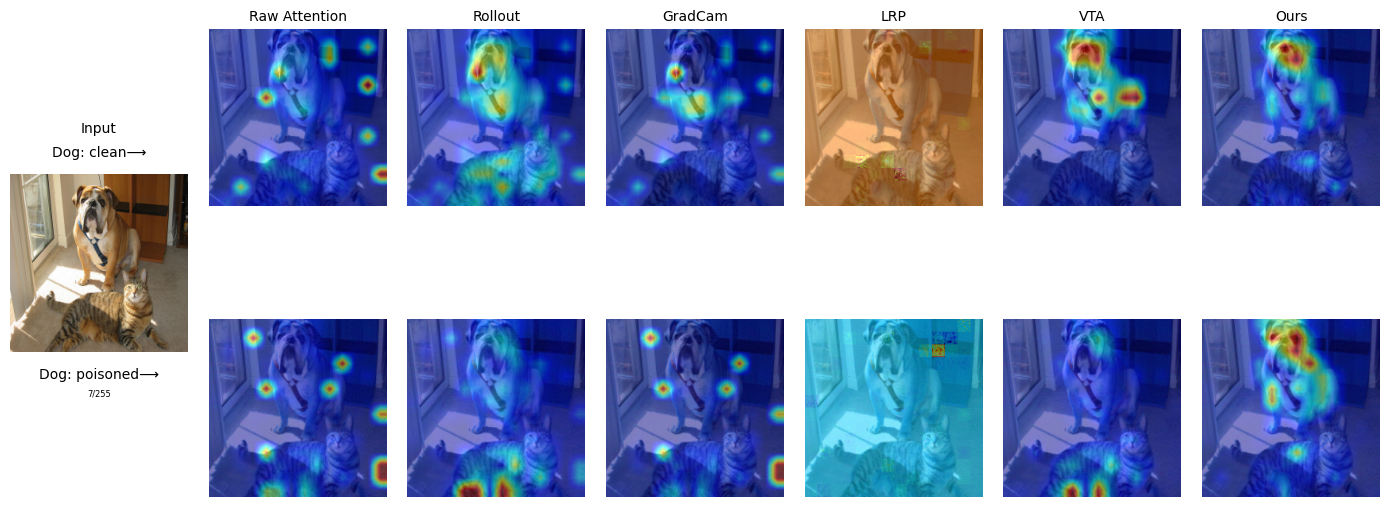

In [2]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 7, width_ratios=[1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1])

# Choose image from samples
path = "./fig/catdog.png"
cls_idx = 243
try: 
    image = Image.open(path)
except:
    image = Image.open(path).convert('RGB')
image_trans = transform(image)

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# Place the original image in the middle left
ax_input = plt.subplot(gs[:, 0])  # Span both rows for the left column
ax_input.imshow(image)
ax_input.axis('off')
ax_input.set_title("Input", fontsize=10, pad=30)
ax_input.text(
    0.5, 1.1, "Dog: clean⟶", ha='center', transform=ax_input.transAxes
)
ax_input.text(
    0.5, -0.15, "Dog: poisoned⟶", ha='center', transform=ax_input.transAxes
)
ax_input.text(
    0.5, -0.25, "7/255", fontsize=6, ha='center', transform=ax_input.transAxes
)

# Remaining visualizations
methods = ['last_layer_attn', 'rollout', 'attn_gradcam', 'full', None, 'transformer_attribution']
titles = ['Raw Attention', 'Rollout', 'GradCam', 'LRP', 'VTA', 'Ours']

# Generate poisoned image
noise_level = 7 / 255
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level, label_index=cls_idx)

for i, (method, title) in enumerate(zip(methods, titles)):
    if title == 'Ours':
        # Custom logic for "Ours"
        steps = 1000
        start = 0.0001
        end = 0.02
        trial_num = 2
        opt_t = get_opt_t(noise_level, start, end, steps)

        dog_lists = []
        dogp_lists = []
        for _ in range(trial_num):
            image_trans_denoised = trans_to_224(
                denoise(trans_to_256(image_trans), opt_t, steps, start, end, noise_level)
            ).detach().cpu()
            image_trans_denoise_normal = image_trans_denoised + torch.randn_like(image_trans_denoised) * noise_level
            image_trans_denoise_normal = torch.squeeze(image_trans_denoise_normal)
            image_trans_denoise_normal = torch.clamp(image_trans_denoise_normal, -1, 1)

            poisoned_image = attack(image_trans.unsqueeze(0).to(device), model, noise_level, label_index=cls_idx)
            poisoned_image_denoised = trans_to_224(
                denoise(trans_to_256(poisoned_image).squeeze(0), opt_t, steps, start, end, noise_level)
            ).detach().cpu()
            poisoned_image_denoised = poisoned_image_denoised + torch.randn_like(poisoned_image_denoised) * noise_level
            poisoned_image_denoised = torch.squeeze(poisoned_image_denoised)
            poisoned_image_denoised = torch.clamp(poisoned_image_denoised, -1, 1)

            dog = get_importance_maps(image_trans_denoise_normal, class_index=cls_idx, method="transformer_attribution")
            dog_p = get_importance_maps(poisoned_image_denoised, class_index=cls_idx, method="transformer_attribution")


            dog_lists.append(dog)
            dogp_lists.append(dog_p)

        dog = drop_lowest_max_fuse(dog_lists)
        dogp = drop_lowest_max_fuse(dogp_lists)
        dog = normal(dog)
        dogp = normal(dogp)

        dog = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dog)
        dog_p = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dogp)
    else:
        # Logic for other methods
        dog = generate_visualization(image_trans, class_index=cls_idx, method=method) if method else generate_visualization(image_trans, class_index=cls_idx)
        dog_p = generate_visualization(image_trans_per_dog.squeeze(0), class_index=cls_idx, method=method, p=True) if method else generate_visualization(image_trans_per_dog.squeeze(0), class_index=cls_idx, p=True)

    # Top row
    ax = plt.subplot(gs[0, i + 1])
    ax.imshow(dog)
    ax.axis('off')
    ax.set_title(title, fontsize=10)

    # Bottom row
    ax_p = plt.subplot(gs[1, i + 1])
    ax_p.imshow(dog_p)
    ax_p.axis('off')

# Adjust layout
plt.tight_layout(h_pad=0.8, w_pad=1.5)
plt.show()


# 3. Extensions visualisation

Top 5 classes:
	282 : tiger cat       		value = 10.558	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.058	 prob = 15.3%
	285 : Egyptian cat    		value = 8.413	 prob = 8.0%
	243 : bull mastiff    		value = 7.426	 prob = 3.0%
	811 : space heater    		value = 5.151	 prob = 0.3%
Top 5 classes:
	282 : tiger cat       		value = 10.558	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.058	 prob = 15.3%
	285 : Egyptian cat    		value = 8.413	 prob = 8.0%
	243 : bull mastiff    		value = 7.426	 prob = 3.0%
	811 : space heater    		value = 5.151	 prob = 0.3%


100%|██████████| 45/45 [00:03<00:00, 13.97it/s]


<Figure size 1400x600 with 0 Axes>

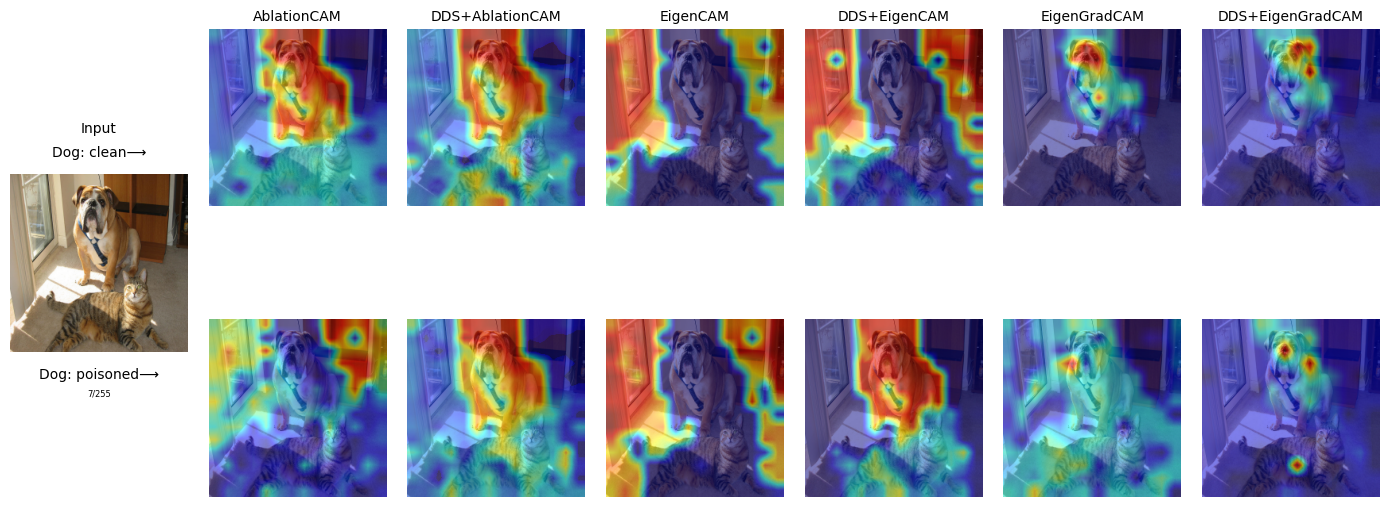

In [3]:
#################################################################################################################################

"""
    methods_2 = the methpds
    titles_2 = the plot title and is also responsible to activate DDS

    dds_method = add new DDS+[method] for new combinations or else the DDS won't activate
"""


# Change

methods_2 = ['ablationcam', 'ablationcam', 'eigencam', 'eigencam', "eigengradcam", 'eigengradcam']
titles_2 = ['AblationCAM', 'DDS+AblationCAM', 'EigenCAM', 'DDS+EigenCAM', 'EigenGradCAM', 'DDS+EigenGradCAM']
dds_method = ['DDS+EigenCAM', 'DDS+EigenGradCAM', 'DDS+AblationCAM']


# Keys are the methods activator

# methods = \
#         {"gradcam": GradCAM,
#          "scorecam": ScoreCAM,
#          "gradcam++": GradCAMPlusPlus,
#          "ablationcam": AblationCAM,
#          "xgradcam": XGradCAM,
#          "eigencam": EigenCAM,
#          "eigengradcam": EigenGradCAM,
#          "layercam": LayerCAM,
#          "fullgrad": FullGrad}


#################################################################################################################################

import cv2
import numpy as np
import torch

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from baselines_mod.ViT.ViT_pytorch_cam import vit_base_patch16_224 as vitmodel


import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 1] , height_ratios=[1, 1])

# Choose image from samples
path = "./fig/catdog.png"
cls_idx = 243
try: 
    image = Image.open(path)
except:
    image = Image.open(path).convert('RGB')

image_trans = transform(image)

model = vitmodel(pretrained=True).to(device).eval()

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


def generate_new_explanation_method(model, input_img, org_img, method="ablationcam", targets=None):

    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

    target_layers = [model.blocks[-1].norm1]

    if method == 'ablationcam':
        cam = methods[method](model=model,
                target_layers=target_layers,
                reshape_transform=reshape_transform,
                ablation_layer=AblationLayerVit())
    else:
        cam = methods[method](model=model,
                    target_layers=target_layers,
                    reshape_transform=reshape_transform)

 
    # targets = None
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_img,
                    targets=targets)
    grayscale_cam = grayscale_cam[0, :]


    rgb_img = np.array(org_img)
    rgb_img = np.float32(rgb_img) / 255

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.5)
    return cam_image


import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 7, width_ratios=[1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1])

# Choose image from samples
path = "./fig/catdog.png"
cls_idx = 243
try: 
    image = Image.open(path)
except:
    image = Image.open(path).convert('RGB')
image_trans = transform(image)

model = vitmodel(pretrained=True).to(device).eval()

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# Place the original image in the middle left
ax_input = plt.subplot(gs[:, 0])  # Span both rows for the left column
ax_input.imshow(image)
ax_input.axis('off')
ax_input.set_title("Input", fontsize=10, pad=30)
ax_input.text(
    0.5, 1.1, "Dog: clean⟶", ha='center', transform=ax_input.transAxes
)
ax_input.text(
    0.5, -0.15, "Dog: poisoned⟶", ha='center', transform=ax_input.transAxes
)
ax_input.text(
    0.5, -0.25, "7/255", fontsize=6, ha='center', transform=ax_input.transAxes
)

# Remaining visualizations

methods1 = {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}




# Generate poisoned image
noise_level = 8 / 255
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level, label_index=cls_idx)



def generate_new_explanation_method_2(model, input_img, org_img, method="ablationcam", targets=None):

    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

    target_layers = [model.blocks[-1].norm1]

    if method == 'ablationcam':
        cam = methods[method](model=model,
                target_layers=target_layers,
                reshape_transform=reshape_transform,
                ablation_layer=AblationLayerVit())
    else:
        cam = methods[method](model=model,
                    target_layers=target_layers,
                    reshape_transform=reshape_transform)

 
    # targets = None
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_img,
                    targets=targets)
    grayscale_cam = grayscale_cam[0, :]


    rgb_img = np.array(org_img)
    rgb_img = np.float32(rgb_img) / 255

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.5)
    return grayscale_cam

for i, (method, title) in enumerate(zip(methods_2, titles_2)):
   
    # Logic for other methods

    if title in dds_method:
           # Custom logic for "Ours"
        steps = 1000
        start = 0.0001
        end = 0.02
        trial_num = 2
        opt_t = get_opt_t(noise_level, start, end, steps)

        dog_lists = []
        dogp_lists = []
        for _ in range(trial_num):
            image_trans_denoised = trans_to_224(
                denoise(trans_to_256(image_trans), opt_t, steps, start, end, noise_level)
            ).detach().cpu()
            image_trans_denoise_normal = image_trans_denoised + torch.randn_like(image_trans_denoised) * noise_level
            image_trans_denoise_normal = torch.squeeze(image_trans_denoise_normal)
            image_trans_denoise_normal = torch.clamp(image_trans_denoise_normal, -1, 1)

            poisoned_image = attack(image_trans.unsqueeze(0).to(device), model, noise_level, label_index=cls_idx)
            poisoned_image_denoised = trans_to_224(
                denoise(trans_to_256(poisoned_image).squeeze(0), opt_t, steps, start, end, noise_level)
            ).detach().cpu()
            poisoned_image_denoised = poisoned_image_denoised + torch.randn_like(poisoned_image_denoised) * noise_level
            poisoned_image_denoised = torch.squeeze(poisoned_image_denoised)
            poisoned_image_denoised = torch.clamp(poisoned_image_denoised, -1, 1)


            dog = generate_new_explanation_method_2(model, image_trans_denoise_normal.unsqueeze(0), image, method=method, targets=[ClassifierOutputTarget(243)])
            dog_p = generate_new_explanation_method_2(model, poisoned_image_denoised.unsqueeze(0), image, method=method, targets=[ClassifierOutputTarget(243)])

            dog_lists.append(dog)
            dogp_lists.append(dog_p)


        rgb_img = np.array(image)
        rgb_img = np.float32(rgb_img) / 255

        dog = drop_lowest_max_fuse(dog_lists)
        dogp = drop_lowest_max_fuse(dogp_lists)
        dog = normal(dog)
        dogp = normal(dogp)

        dog = show_cam_on_image(rgb_img, dog, use_rgb=True, image_weight=0.5)
        dog_p = show_cam_on_image(rgb_img, dogp, use_rgb=True, image_weight=0.5)


    else:
        dog = generate_new_explanation_method(model, image_trans.unsqueeze(0), image, method=method, targets=[ClassifierOutputTarget(243)])
        dog_p = generate_new_explanation_method(model, image_trans_per_dog, image, method=method, targets=[ClassifierOutputTarget(243)])

    # Top row
    ax = plt.subplot(gs[0, i + 1])
    ax.imshow(dog)
    ax.axis('off')
    ax.set_title(title, fontsize=10)

    # Bottom row
    ax_p = plt.subplot(gs[1, i + 1])
    ax_p.imshow(dog_p)
    ax_p.axis('off')

# Adjust layout
plt.tight_layout(h_pad=0.8, w_pad=1.5)
plt.show()